In [1]:
import torch.nn.functional as F
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np
import torch
from torch.optim import Adam
from torch import nn
from datasets import load_dataset
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

### Part 1. On attention [2 points]

Answer each question in max. 3 lines. Points will be subtracted for long answers so be short and precise. Add your explanations in the below box - NO added handwritten images, write in latex!

1. [0.5 point] You are given an input $X=[x_1,...,x_L]$ (e.g. a sentence of tokenised words). Your goal is to predict the next token $x_i$ conditional on $x_{1},...,x_{i}$. In other words, the $i$-th position can only be influenced by a position $j$ if and only if $j \leq i$, namely a position cannot be influenced by the subsequent positions.
    a. What would be the problem when passing $X$ through attention? Explain using the computations that attention performs, e.g. you can write out the matrix multiplication. 
    b. How could you ensure that the prediction for position $i$ depends solely on positions $j\leq i$? Hint: what in the attention computation should be masked & in what way? 
2. [0.5 point] Let's consider multi-head attention. How does multi-head attention change the computations inside the softmax (the $QK^T$ term) and the product with $V$ and why could this be beneficial to learning? 
3. [0.5 point] Remember that standard attention is given by 
\begin{align}
Q = XW^Q, \; K=XW^K, \; V=XW^V, \;\; \textnormal{with} A(X) = softmax\left(\frac{QK^T}{\sqrt{D}}\right)V
\end{align}
for a sequence $X\in\mathbb{R}^{L\times D}$ with $L$ the sequence length. 
What is the memory and computational cost of attention in terms of the sequence length and where does this come from? 
4. [0.5 point] A big focus these days is on making attention more computationally efficient. The $i$-th row (as a vector) of attention can be rewritten as, 
\begin{align}
A(X)_i = \frac{\sum_{j=1}^L sim(Q_i,K_j)V_j}{\sum_{j=1}^L sim(Q_i,K_j)},
\end{align}
with $sim(q,k)=exp(q^Tk/\sqrt{D})$.
Linear attention would be given by, 
\begin{align}
A(X)_i = \frac{\sum_{j=1}^L \phi(Q_i)^T\phi(K_j)V_j}{\sum_{j=1}^L\phi(Q_i)^T\phi(K_j)}. 
\end{align} 
Explain the relation between regular attentin and linear attention (i.e. what kind of similarity function does linear attention assume and how is the approximation made?) & how the above expression can be rewritten and use this to explain why linear attention computation can be done more efficiently compared to standard attention. 

Fill in your answers below. 

1. 

2. 

3. 

4. 

### Part 2. On diffusion models [12 points]

We will be implementing a diffusion model. We will follow mostly the setup as done here: https://arxiv.org/pdf/2006.11239.pdf so please refer to this work for more details if needed. 

Your goal will be to implement the code for the diffusion model, find the right configuration to train the model, achieve good accuracy and efficiency and finally interpret how the model learns. You will be marked on clean code, concise answers and good results. 

We will be working with the FashionMNIST dataset. You can load the data using the below code. 

In [134]:
IMG_SIZE = 28
BATCH_SIZE = 128

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
channels = 1

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

dataloader = DataLoader(transformed_dataset['train'], batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

The following helper functions will be useful. In particular, whenever we input a vector (list) of values, this will help to select the right time t output. We will use this in the sampling loops. 

In [23]:
def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

##### 1. The noising process [2 points]

[1.5 pts] Our first step will be to implement the forward process that adds noise to an image. 

We will be adding noise according to a linear schedule, i.e. the noises $\beta_t$, $t=1,...,T$ will come from an equally spaced vector. Implement the `linear_beta_schedule` function. Remember $\alpha_t = 1-\beta_t$ and $\bar \alpha_t = \prod_{s=1}^t \alpha_s$. 

Remember that we have the closed-form solutions for the image at time $t$. Use those in the implementation of `forward_diffusion_sample` instead of a for loop over each noising step. This means you will need to implement `sqrt_one_minus_alphas_cumprod` which represents $\sqrt{1-\bar\alpha_t}$ and `sqrt_alphas_cumprod` which represents $\sqrt{\bar\alpha_t}$. 

Test the function on an image from the dataset using the given code below. 

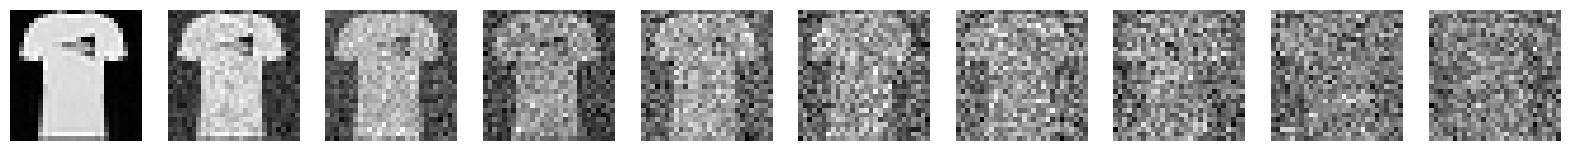

In [228]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    '''
    output a vector of size timesteps that is equally spaced between start and end; this will be the noise that is added in each time step. 

    Args:
    timesteps: int, number of time steps
    start: float, start value of the schedule
    end: float, end value of the schedule
    '''

    betas = torch.linspace(start, end, timesteps)
    return betas


def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    Hint: use the get_index_from_list function to select the right values at time t. 
    """
    batch_size = x_0.shape[0]
    noise = torch.randn(batch_size, 1, IMG_SIZE, IMG_SIZE, device=device)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_T = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    
    x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_T * noise

    return x_t, noise

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
# ADD HERE THE COMPUTATIONS NEEDED for sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod
alphas = 1 - betas

sqrt_alphas_cumprod = torch.sqrt(alphas.cumprod(dim=0))
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas.cumprod(dim=0))


# Simulate forward diffusion
batch = next(iter(dataloader))["pixel_values"]
num_images = 10
stepsize = int(T/num_images)

fig, ax = plt.subplots(1, num_images, figsize=(20, 5))

for i, idx in enumerate(range(0, T, stepsize)):
    t = torch.Tensor([idx]).type(torch.int64)
    img, noise = forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    ax[i].imshow(img.reshape(28, 28), cmap="gray")
    ax[i].axis('off')

[0.5 pt] Play around with the noise (compare two different beta schedules), present results for the two settings and discuss (in max. 3 lines) how the hyperparameters change the forward sampling. 

##### 2. The model for the noise [4 points]

We use a simple form of a UNet to predict the noise in the image. The input into the neural network will be a noisy image and the ouput from the model will be the noise in the image. It is important to also pass in the timestep into the neural network (so the model knows at which time we want to denoise the image) and we do this by passing it through a sinusoidal position embedding. 

[0.5pt] Write code for the Sinusoidal Position Embedding. This should output a matrix $PE$ of size `[timesteps, dimension]` with elements:

\begin{align}
&PE_{pos,2i} = \sin\left(\frac{pos}{10000^{2i/dim}}\right),\\
&PE_{pos,2i+1} = \cos\left(\frac{pos}{10000^{2i/dim}}\right),
\end{align}
where `pos` refers to the time position and `i` refers to the dimension position and `dim` the total dimension we are working with. 

Use however the following identity to implement: 
\begin{align}
\frac{pos}{10000^{2i/dim}} = \exp\left(\log(pos) - \frac{2i}{dim}\log(10000)\right).
\end{align}

In [138]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        '''
        Fill in the code
        
        Args:
        time: tensor, the time steps

        Returns:
        ret_matrix: tensor, the position embeddings for the given time steps
        '''
        
        ret_matrix = torch.zeros(len(time), 0)

        for i in range(self.dim):
            col_intermediary_val = torch.exp((torch.log(time) - torch.log(torch.tensor(10000)) * (
                (i - (i % 2)) / self.dim))).unsqueeze(1)
            
            if i % 2 == 0:
                col_val = torch.sin(col_intermediary_val)
            else:
                col_val = torch.cos(col_intermediary_val)
            
            ret_matrix = torch.cat((ret_matrix, col_val), dim=1)

                
        return ret_matrix



[0.5pt] Visualise the positional embeddings with arbitary time and dimension and discuss what position embeddings do (why do we add them, why this particular embedding structure) in max. 3 lines. 

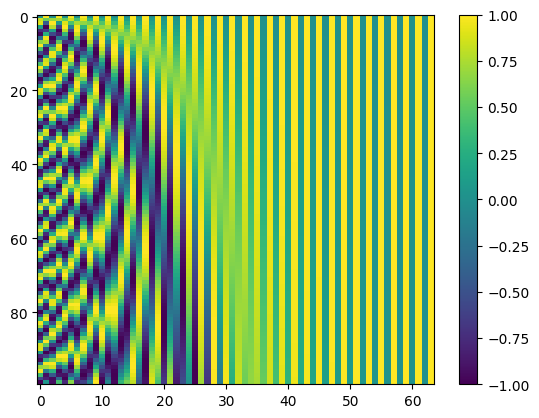

In [139]:
# Write here the code to visualise the positional embedding
position_embeddings = SinusoidalPositionEmbeddings(64)
time = torch.tensor(range(100))
pos_emb = position_embeddings(time)
plt.imshow(pos_emb, aspect="auto")
plt.colorbar()
plt.show()


Add here your discussion on the positional embeddings.

Below is the code for a Block, that will make up the final UNet. 

[0.5pt] Fill in the missing parts. 

Remember that in the UNet architecture, we have a downsampling phase and an upsampling phase. Depending on which phase we are in, we need to make use of the up or down-sample operations. 

[0.5pt] Add here an explanation as to what the block does including the up and downsample operations in maximum 3 lines:

Explanation of a Block: YOUR ANSWER GOES HERE

In [142]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        '''
        in_ch refers to the number of channels in the input to the operation and out_ch how many should be in the output
        '''
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t):
        '''
        Define the forward pass making use of the components above. 
        Time t should get mapped through the time_mlp layer + a relu
        The input x should get mapped through a convolutional layer with relu / batchnorm
        The time embedding should get added the output from the input convolution 
        A second convolution should be applied and finally passed through the self.transform. 
        '''

        time_emb = self.time_mlp(t)
        time_emb = self.relu(time_emb)


        x = self.conv1(x)
        x = self.relu(x)
        x = self.bnorm1(x)

        x = x + time_emb.unsqueeze(2).unsqueeze(3)
        x = self.conv2(x)

        #NOT SURE ABOUT THIS BIT
        x = self.relu(x)
        x = self.bnorm2(x)

        x = self.transform(x)

        return x
        

[1.5pt] Use the above code to fill in the code for the UNet below. 

In [233]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (32, 64, 128) # These are the channels that we want to obtain in the downsampling stage; DEFINE YOURSELF!
        up_channels = (128, 64, 32) # These are the channels that we want to obtain in the upsampling stage; DEFINE YOURSELF!
        out_dim =  1 # DEFINE THIS CORRECTLY 
        time_emb_dim = 28 # DEFINE THIS CORRECTLY

        # Time embedding consists of a Sinusoidal embedding, a linear map that maintains the dimensions and a rectified linear unit activation. 
        self.time_emb = SinusoidalPositionEmbeddings(dim = time_emb_dim)
        self.tim_emb2 = nn.Sequential(nn.Linear(time_emb_dim, time_emb_dim), 
                                      nn.ReLU())
        
        # Initial projection consisting of a map from image_channels to down_channels[0] with a filter size of e.g. 3 and padding of 1. 
        # TO WRITE CODE

        self.initial_projection = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample: use the Blocks given above to define down_channels number of downsampling operations. These operations should cha
        # TO WRITE CODE HERE; HINT: use something like Block(down_channels[i], down_channels[i+1], time_emb_dim) the right number of times. 
        
        self.downsample = nn.Sequential()
        for i in range(len(down_channels) - 1):
            self.downsample.add_module(f"block_{i}", Block(down_channels[i], down_channels[i+1], time_emb_dim))

        # Upsample
        self.upsample = nn.Sequential()
        for i in range(len(up_channels) - 1):
            self.upsample.add_module(f"block_{i}", Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True))
        
        # Final output: given by a final convolution that maps up_channels[-1] to out_dim with a kernel of size 1. 
        
        self.out_func = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, time):
        # Embedd time
        t = self.time_emb(time)
        t = self.tim_emb2(t)
        
        #Initial projection
        x = self.initial_projection(x)

        # Unet: iterate through the downsampling operations and the upsampling operations. Do not forget to include the residual connections 
        # between the outputs from the downsample stage and the upsample stage.

        downsample_outputs = []

        for block in self.downsample:
            x = block(x, t)
            downsample_outputs.append(x)

        
        #FIX CONCATENATION
        for i, block in enumerate(self.upsample):
            x = torch.cat((x, downsample_outputs[-(i+1)]), dim=1)
            x = block(x, t)

        x = self.out_func(x)
        
        return x 


[0.5pt] Finally, define a loss function. Note that this loss function should take x_0 and t to sample the forward diffusion model, get a noisy image, use this noisy image in the model to get the noise added and finally compare true added noise and model outputs added noise. 

In [169]:
def get_loss(model, x_0, t):
    '''
    Define the right loss given the model, the true x_0 and the time t
    '''
    noisy_x, true_noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)    
    predicted_noise = model(noisy_x, t)

    return F.mse_loss(predicted_noise, true_noise)

##### Part 3: The sampling [1 point]

Write a piece of code that can be used to predict the noise and return the denoised image. This function should work on a single image and make sure that the function can be used in the `sample` function properly. Note that we will need the `posterior_variance` denoted by $\sigma$ in the paper and the `sqrt_recip_alphas` given by $1/\alpha_t$. Make sure to set the right choice of $\sigma$ (see the paper). 

In [256]:
# compute posterior_variance 
#COME BACK TO THIS
posterior_variance = betas # FILL IN WITH THE RIGHT SETUP;
sqrt_recip_alphas = torch.reciprocal(torch.sqrt(alphas)) # FILL IN WITH THE RIGHT SETUP; 

@torch.no_grad()
def sample_timestep(x, t, i, posterior_variance, sqrt_one_minus_alphas_cumprod, alphas, sqrt_recip_alphas, model):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    Note that it also needs additional arguments about the posterior_variance, sqrt_minus_alphas_cumprod and sqrt_recip_alphas. 
    """
    
    predicted_noise = model(x, t)
        
    rand_noise =  posterior_variance[i] ** (1/2) * torch.randn_like(x)

    denoised_img = sqrt_recip_alphas[i] * (x - (1 - alphas[i]) / sqrt_one_minus_alphas_cumprod[i] * predicted_noise) 

    if i == 0:
        return denoised_img
    
    return denoised_img + rand_noise

@torch.no_grad()
def sample(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, i, posterior_variance, sqrt_one_minus_alphas_cumprod, alphas, sqrt_recip_alphas, model)
        imgs.append(img.cpu().numpy())
    return imgs

##### Part 4. Write the training loop and present & interpret your results [6 points]

Code a training loop that instantiates the model, defines an optimiser, defines a number of epochs, iterates over the epochs and the datapoints inside the epoch and for each iteration samples a timestep, uses this timestep to loss function and update parameters based on this. 

Note: this is the part requiring most computational resources. You may need to train the model for quite a few epochs to get good results. Be sure to start on time to ensure enough access to GPUs on Google Colab. 

0.5 point will be given for correct implementation. 

1.5 points will be given according to how many **sensible** samples (with max points given for 10 good samples; scaled accordingly for less samples) you manage to obtain (i.e. the performance of your model in generating good datapoints). 

2 points will be given according to how efficient you can make the train process to still produce at least 10 good samples. You are free to change anything in the architecture! Your output will be compared to my base setup which uses `50` epochs and has a model with `Num params:  929409`. 1 point will be assigned scaled according to how much less epochs you can use and 1 points scaled with how much less params you manage to use. Be sure to print your number of parameters, training epochs and the 10 sensible images. 

2 points will be given for the interpretation of your results that allows us to better understand *how* the model learns. For this you are asked to visualise the generated samples during the training process. Can you identify any properties of *how* the model learns? Are there particular aspects the model starts paying attention to / is able to generate before others? 

In [247]:
model = SimpleUnet()

In [257]:
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 1 

#Problem here is treating time_step as bath_size so we need have to fix timestep to be a int (128) or 
#change how timestep is handled

for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        batch = batch["pixel_values"]
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,))
        loss = get_loss(model, batch, t)
        loss.backward()
        optimizer.step()

        print(f"Batch No. {i} / {len(dataloader)}: Loss: {loss.item()}")

Batch No. 0 / 468: Loss: 0.10553054511547089
Batch No. 1 / 468: Loss: 0.19721724092960358
Batch No. 2 / 468: Loss: 0.15892980992794037
Batch No. 3 / 468: Loss: 0.13300591707229614
Batch No. 4 / 468: Loss: 0.11498218774795532
Batch No. 5 / 468: Loss: 0.12465483695268631
Batch No. 6 / 468: Loss: 0.13173125684261322
Batch No. 7 / 468: Loss: 0.13153885304927826
Batch No. 8 / 468: Loss: 0.11935494095087051
Batch No. 9 / 468: Loss: 0.12199199199676514
Batch No. 10 / 468: Loss: 0.09266125410795212
Batch No. 11 / 468: Loss: 0.11183377355337143
Batch No. 12 / 468: Loss: 0.12643179297447205
Batch No. 13 / 468: Loss: 0.0986720621585846
Batch No. 14 / 468: Loss: 0.102590411901474
Batch No. 15 / 468: Loss: 0.09647782146930695
Batch No. 16 / 468: Loss: 0.10092964768409729
Batch No. 17 / 468: Loss: 0.1222023069858551
Batch No. 18 / 468: Loss: 0.10801533609628677


KeyboardInterrupt: 

In [258]:
samples = sample(model, (10, 1, 28, 28))

sampling loop time step: 100%|██████████| 300/300 [00:08<00:00, 36.28it/s]


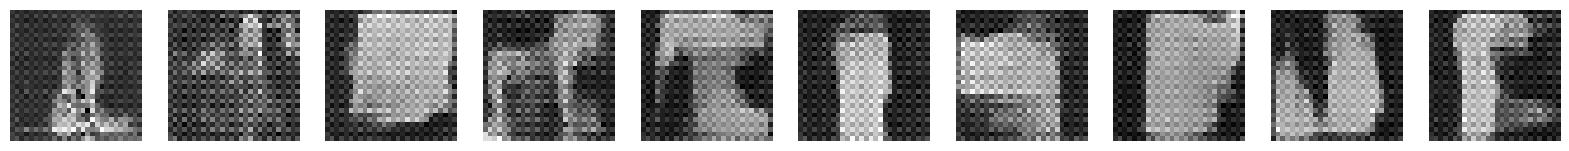

In [296]:
#plot the last of each sample
fig, ax = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(samples[-1][i].reshape(28, 28), cmap="gray")
    ax[i].axis('off')


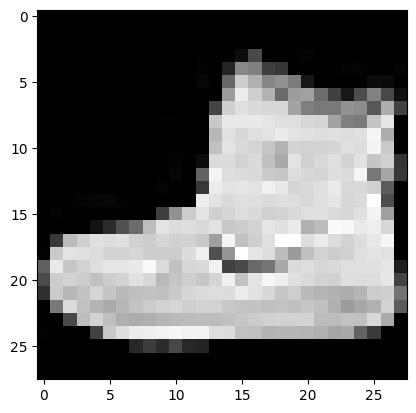

In [219]:
plt.imshow(dataloader.dataset[0]["pixel_values"].reshape(28, 28), cmap="gray")

Finally, after training is done, use the `sample` to sample new images. 

In [220]:
# Code for the plotting of samples goes here

Include your best generated samples below. 

In [ ]:
# Code to show the best samples goes here

Include your most efficient implementation details below. 

In [235]:
# Code to make your most efficient setup goes here; present all code from above in one Code block
# run it to show final runtimes and print out the total number of parameters in the model. 


total_params = sum(p.numel() for p in model.parameters())
print("Total parameters in the model:", total_params)


Total parameters in the model: 928013


Interpretation of your results goes here. 

In [1]:
# Here goes the code for visualising during training and add a discussion above. 

### Part 3. On DeepDream [5 points]

In this task we will implement a DeepDream model in order to generate ‘dreams’: images enhanced by the neural network. 

Here we will work with a pre-trained model (Inception-V3). The idea is as follows: we will load some image (you can later on choose to load your own image if you want). We will load the Inception-V3 model. We will pass it an input and obtain the activation outputs from a certain layer. We will 'ask' the neural network to maximise the values of the activation, i.e. enhance the image with what those layer activations 'like' to see. For this we will implement a gradient ascent method in order to maximise a norm of the activations over that input. This will change our input into a `dream'. 

1. [1 point] Write a piece of code that will load the Inception-V3 model and allow you to get access to the intermediate activations. 

2. [2 points] Implement the deepdream optimisation loop. We will use gradient ascent to optimise for the norm of the activation. Implement a function that performs this gradient ascent. This function will take as input the number of iterations to perform, the learning rate, and the start image (i.e. the image which the model will enhance). Define in the function a for loop over the number of iterations, obtain the model output, get the output of the hook (hint: use something like `outputs[-1]`), compute the loss which will be L2 norm of this output (i.e. the L2 norm of the activations from your chosen layer), compute the gradients of this L2 norm loss, scale the gradients by their absolute average (hint: scale using `torch.abs(g).mean()`) and define a gradient ascent step over the image. Do not forget to zero out gradients where needed. 

3. [1 point] Implement code to load an image (e.g. https://github.com/pytorch/hub/raw/master/images/dog.jpg) and display the output from your optimisation loop (using e.g. numpy). Present the generated images for different choices of layer activations and different number of optimisation steps. Discuss your results. What is the impact of using different layers? What is the impact of the number of optimisation steps? [0.5 point will be given for the implementation and 1.5 point for a very good discussion]

4. [1 point] In our previous setting we allowed for optimising for a single layer's activation. Change the method such that it will allow to compute the loss (L2 norm) of multiple layers' outputs. Present three different setups using different numbers & combinations of layers and discuss your results in max. 3 lines. 

In [298]:
import torch
import torchvision.models as models

# Load the InceptionV3 model
deep_model = models.inception_v3(pretrained=True)

# Set the model to evaluation mode
deep_model.eval()

# Register a forward hook to capture intermediate activations
intermediate_activations = []

def capture_activations(module, input, output):
    intermediate_activations.append(output)

# Register the forward hook to all the modules in the model
for module in model.modules():
    module.register_forward_hook(capture_activations)


C:\Users\afshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\afshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [300]:

def deepdream_optimization_loop(iterations, learning_rate, start_image):
    # Set the model to evaluation mode
    deep_model.eval()
    
    # Create a hook to capture the intermediate activations
    intermediate_activations = []
    def hook(module, input, output):
        intermediate_activations.append(output)
    
    # Register the hook to the chosen layer
    layer = model.Conv2d_2a_3x3
    hook_handle = layer.register_forward_hook(hook)
    
    # Convert the start image to a tensor and set requires_grad to True
    image_tensor = torch.tensor(start_image, dtype=torch.float32, requires_grad=True)
    
    # Perform gradient ascent for the specified number of iterations
    for i in range(iterations):
        # Zero out the gradients
        image_tensor.grad = None
        
        # Forward pass through the model
        outputs = model(image_tensor)
        
        # Get the output of the chosen layer
        layer_output = intermediate_activations[-1]
        
        # Compute the L2 norm loss
        loss = torch.norm(layer_output)
        
        # Compute the gradients of the loss
        loss.backward()
        
        # Scale the gradients by their absolute average
        gradients = image_tensor.grad
        scaled_gradients = gradients / torch.abs(gradients).mean()
        
        # Gradient ascent step
        image_tensor.data += learning_rate * scaled_gradients
        
        # Clip the pixel values to the range [0, 1]
        image_tensor.data = torch.clamp(image_tensor.data, 0, 1)
    
    # Remove the hook
    hook_handle.remove()
    
    # Convert the optimized image tensor back to a numpy array
    optimized_image = image_tensor.detach().numpy()
    
    return optimized_image


In [316]:
import requests
from PIL import Image

from io import BytesIO
url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image.show()

import torchvision.transforms as transforms

# Convert the image to a PyTorch tensor
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0)

In [317]:

optimised_img = deepdream_optimization_loop(100, 0.01, image_tensor)


C:\Users\afshe\AppData\Local\Temp\ipykernel_20988\1967406964.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(start_image, dtype=torch.float32, requires_grad=True)


: 

In [313]:
image_tensor[:,0,0]

tensor([0.0510, 0.1176, 0.0471])

sampling loop time step: 100%|██████████| 300/300 [00:08<00:00, 36.28it/s]
